# 1.导入库文件

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.svm as svm
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import   BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import csv
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from bayes_opt import BayesianOptimization

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 2.进行数据导入以及标准化

In [37]:
df = pd.read_csv('winequality-red.csv')

In [38]:
def draw_multivarient_plot(dataset, rows, cols, plot_type):

    column_names=dataset.columns.values

    number_of_column=len(column_names)

    fig, axarr=plt.subplots(rows,cols, figsize=(22,16))

    counter=0
    for i in range(rows):
        for j in range(cols):

            if 'violin' in plot_type:
                sns.violinplot(x='quality', y=column_names[counter],data=dataset, ax=axarr[i][j])
            elif 'box'in plot_type :
                sns.boxplot(x='quality', y=column_names[counter],data=dataset, ax=axarr[i][j])
            elif 'point' in plot_type:
                sns.pointplot(x='quality',y=column_names[counter],data=dataset, ax=axarr[i][j])
            elif 'bar' in plot_type:
                sns.barplot(x='quality',y=column_names[counter],data=dataset, ax=axarr[i][j])
                
            counter+=1
            if counter==(number_of_column-1,):
                break

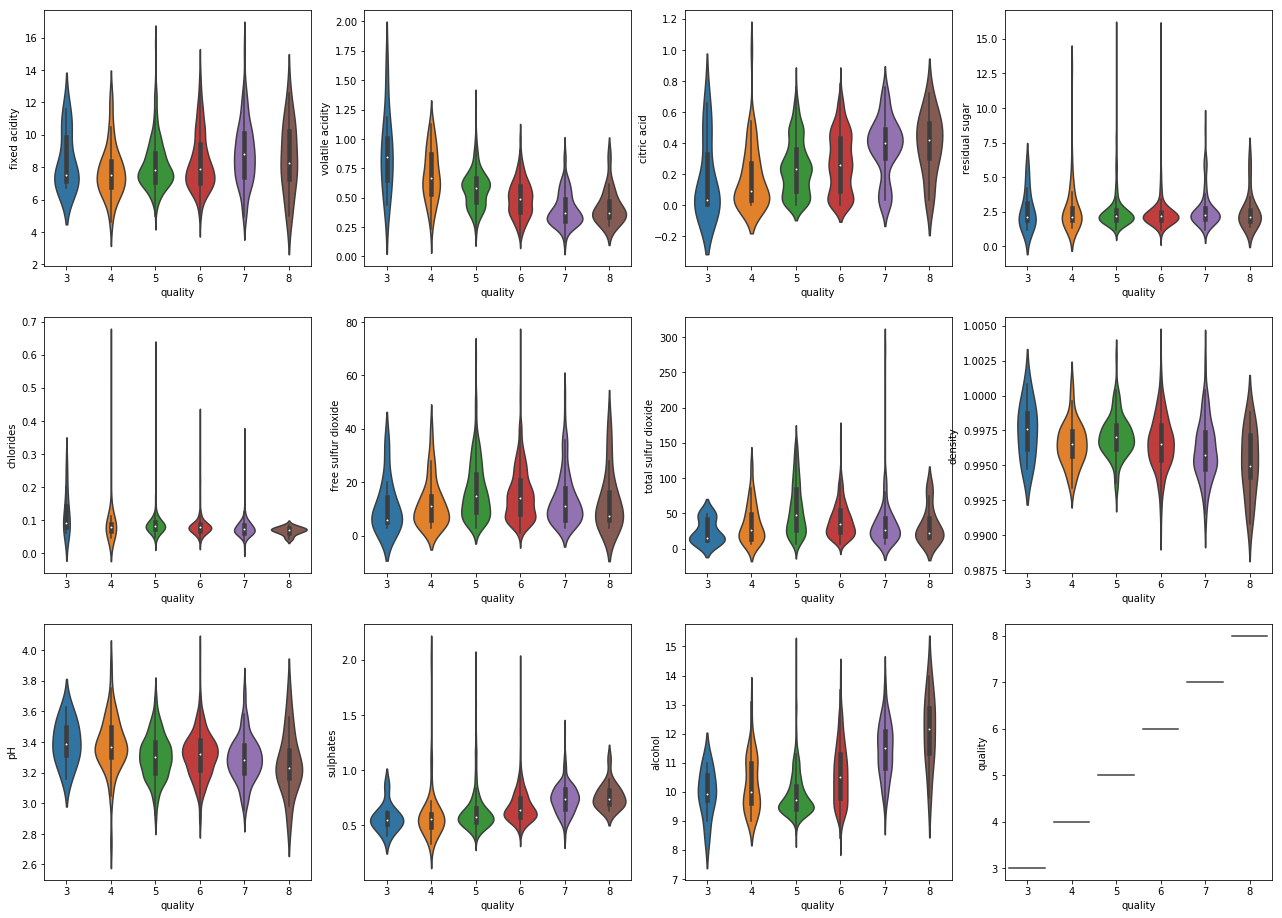

In [41]:
draw_multivarient_plot(df,3,4,'violin')

In [42]:
y = df['quality']
del df['quality']
x = df
x = StandardScaler().fit_transform(x)

# 3.对模型参数进行贝叶斯调优

In [63]:
def bayesopt_rfc(n_estimators, min_samples_split, max_features, max_depth):
    val = cross_val_score(
        RandomForestClassifier(n_estimators=int(n_estimators+0.5),
                               min_samples_split=int(min_samples_split+0.5),
                               max_features=min(max_features, 0.999),  # float
                               max_depth=int(max_depth+0.5),
                               random_state=2),
        x, y, scoring='accuracy', cv=5
    ).mean()
    return val



params_rfc = {'n_estimators': (10, 250), 
           'min_samples_split': (2, 25),
           'max_features': (0.1, 0.999),
           'max_depth': (5, 15)}


opt = BayesianOptimization(
    f=bayesopt_rfc,  
    pbounds=params_rfc,  # 取值空间
    verbose=1,  # verbose = 2 时打印全部，verbose = 1 时打印运行中发现的最大值，verbose = 0 将什么都不打印
    random_state=1,
)
opt.maximize(  # 运行
    init_points=20,  # 随机搜索的步数
    n_iter=100,  # 执行贝叶斯优化迭代次数
)
params_best=opt.max['params'] # 返回最佳参数
score_best=opt.max['target'] # 返回最佳分数

print("best cvscore: ", score_best)
for key,value in params_best.items():
    print(key,' = ',round(value,2),',')

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  2        |  0.5798   |  6.468    |  0.183    |  6.284    |  92.93    |
|  5        |  0.5824   |  9.173    |  0.6023   |  5.229    |  57.54    |
|  12       |  0.5904   |  6.032    |  0.5027   |  22.9     |  80.47    |
|  17       |  0.5904   |  5.5      |  0.5818   |  17.27    |  133.6    |
|  44       |  0.5923   |  5.352    |  0.1821   |  24.13    |  182.0    |
|  110      |  0.5935   |  5.029    |  0.5504   |  3.534    |  242.5    |
best cvscore:  0.5935378022696479
max_depth  =  5.03 ,
max_features  =  0.55 ,
min_samples_split  =  3.53 ,
n_estimators  =  242.48 ,


In [64]:
def bayesopt_xgb(n_estimators,max_depth,learning_rate,subsample,colsample_bytree,min_child_weight,gamma,eta):
    model = xgb.XGBClassifier(max_depth = round(max_depth+0.5),
                              n_estimators = round(n_estimators+0.5),
                              learning_rate = learning_rate,
                              subsample = subsample,
                              colsample_bytree = colsample_bytree,
                              min_child_weight = min_child_weight,
                              gamma = gamma,
                              eta = eta                                                      
                             )
    cv = KFold(n_splits=5,shuffle=True,random_state=7)
    validation_loss=cross_val_score(model
                                   ,x,y
                                   ,scoring='accuracy'
                                   ,cv=cv
                                   ,n_jobs=-1
                                   #,error_score='raise' # 出错时报错，但不停止，如果设置为nan，将停止迭代
                                  )
    return validation_loss.mean()
params_xgb = {
'n_estimators':(80,200),
'max_depth':(2,15),
'learning_rate':(0.01,2),
'subsample':(0.7,0.9),
'colsample_bytree':(0.5,0.98),
'min_child_weight':(1,9),
'gamma':(0,0.5),
'eta':(0.01,0.5)   
}
opt=BayesianOptimization(bayesopt_xgb,params_xgb,random_state=7,verbose=1)
    
opt.maximize(init_points=20,n_iter=100)

params_best=opt.max['params'] # 返回最佳参数
score_best=opt.max['target'] # 返回最佳分数

print("best cvscore: ", score_best)
for key,value in params_best.items():
    print(key,' = ',round(value,2),',')

|   iter    |  target   | colsam... |    eta    |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6498   |  0.5366   |  0.3922   |  0.2192   |  1.45     |  14.71    |  5.308    |  140.1    |  0.7144   |
|  2        |  0.6592   |  0.6289   |  0.2549   |  0.3396   |  1.609    |  6.952    |  1.527    |  114.6    |  0.8819   |
|  3        |  0.6617   |  0.6024   |  0.2315   |  0.4656   |  0.05955  |  9.807    |  8.601    |  107.6    |  0.8097   |
|  4        |  0.6654   |  0.9364   |  0.07525  |  0.2617   |  1.503    |  10.7     |  4.742    |  104.6    |  0.7982   |
|  5        |  0.6573   |  0.6787   |  0.2439   |  0.1829   |  1.677    |  11.99    |  3.512    |  148.7    |  0.7552   |
|  6        |  0.681    |  0.7174   |  0.183    |  0.3287   |  0.747    |  7.968    |  6.755    |  129.6    |  0.8813   |
|  7        |  0.6667   

|  40       |  0.6842   |  0.7393   |  0.01     |  1.197e-0 |  0.01     |  11.76    |  1.0      |  97.64    |  0.7      |
|  41       |  0.6886   |  0.98     |  0.5      |  0.5      |  0.01     |  12.51    |  1.222    |  127.3    |  0.9      |
|  42       |  0.6567   |  0.5354   |  0.3041   |  0.3847   |  0.9258   |  14.9     |  1.166    |  105.3    |  0.8774   |
|  43       |  0.6748   |  0.878    |  0.1163   |  0.009651 |  0.4611   |  2.253    |  1.215    |  105.6    |  0.8747   |
|  44       |  0.606    |  0.98     |  0.5      |  0.03578  |  0.01     |  2.166    |  1.008    |  199.2    |  0.9      |
|  45       |  0.6804   |  0.5027   |  0.2611   |  0.4871   |  0.4129   |  10.65    |  1.071    |  191.2    |  0.852    |
|  46       |  0.6711   |  0.5125   |  0.127    |  0.4292   |  1.069    |  5.591    |  8.351    |  185.2    |  0.8726   |
|  47       |  0.6767   |  0.8152   |  0.0969   |  0.2861   |  0.8482   |  14.97    |  1.042    |  88.36    |  0.8208   |
|  48       |  0.6736   

|  81       |  0.6961   |  0.781    |  0.3319   |  0.4958   |  0.09267  |  7.426    |  1.807    |  105.6    |  0.7885   |
|  82       |  0.6911   |  0.8225   |  0.05071  |  0.3691   |  0.01322  |  11.29    |  1.28     |  172.8    |  0.7346   |
|  83       |  0.7036   |  0.9773   |  0.02768  |  0.2496   |  0.1702   |  14.83    |  1.562    |  175.0    |  0.7497   |
|  84       |  0.6942   |  0.7805   |  0.485    |  0.1974   |  0.09233  |  8.303    |  2.173    |  154.2    |  0.8935   |
|  85       |  0.6504   |  0.5521   |  0.05647  |  0.3053   |  0.02485  |  14.74    |  8.892    |  106.7    |  0.8919   |
|  86       |  0.6141   |  0.9484   |  0.07657  |  0.1958   |  0.07022  |  2.401    |  8.278    |  101.3    |  0.8289   |
|  87       |  0.6936   |  0.5512   |  0.06426  |  0.2608   |  0.1965   |  4.746    |  1.035    |  80.66    |  0.8835   |
|  88       |  0.6442   |  0.9729   |  0.1147   |  0.447    |  0.04512  |  3.49     |  1.614    |  114.5    |  0.8709   |
|  89       |  0.6441   

In [65]:
def bayesopt_lgb(n_estimators,learning_rate,num_iterations,max_depth,min_child_samples, num_leaves,reg_alpha,reg_lambda,colsample_bytree,boosting_type='gbdt'):
    model = lgb.LGBMClassifier(learning_rate = learning_rate,
                               n_estimators = int(n_estimators+0.5),
                              num_iterations = int(n_estimators+0.5),
                              max_depth = int(max_depth+0.5),
                              num_leaves = int(num_leaves+0.5),
                              min_child_samples=int(min_child_samples+0.5),            
                              boosting_type = boosting_type,
                              class_weight='balanced',
                              reg_alpha = reg_alpha,
                              reg_lambda = reg_lambda,
                              colsample_bytree = colsample_bytree
                             )
    cv = KFold(n_splits=5,shuffle=True,random_state=7)
    validation_acc=cross_val_score(model
                                   ,x,y
                                   ,scoring='accuracy'
                                   ,cv=cv
                                   ,n_jobs=-1
                                   #,error_score='raise' # 出错时报错，但不停止，如果设置为nan，将停止迭代
                                  )
    return validation_acc.mean()
params_lgb = {
            'n_estimators':(80,200),
             'learning_rate':(0.01,2),
             'num_iterations':(20,200),
             'max_depth':(2,15),
             'num_leaves': (30,150),
             'min_child_samples':(20,300),
             #'boosting_type': ['gbdt', 'goss', 'dart'],
             'reg_alpha': (0, 1.0),
             'reg_lambda': (0, 1.0),
             'colsample_bytree':(0.6,1)
}

opt=BayesianOptimization(f=bayesopt_lgb,pbounds=params_lgb,random_state=7,verbose=1)
    
opt.maximize(init_points=20,n_iter=100)

params_best=opt.max['params'] # 返回最佳参数
score_best=opt.max['target'] # 返回最佳分数
print("best cvscore: ", score_best)
for key,value in params_best.items():
    print(key,' = ',round(value,2),',')


|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_it... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
|  2        |  0.5647   |  0.8      |  1.362    |  12.45    |  126.7    |  87.91    |  71.87    |  139.2    |  0.2134   |  0.4521   |
|  4        |  0.6323   |  0.9002   |  1.341    |  8.081    |  77.36    |  138.9    |  87.03    |  87.29    |  0.3659   |  0.8379   |
|  5        |  0.6648   |  0.9075   |  0.6348   |  9.444    |  97.29    |  134.3    |  83.54    |  108.9    |  0.3704   |  0.4591   |
|  39       |  0.6648   |  0.9222   |  1.011    |  9.332    |  37.55    |  128.1    |  164.0    |  50.08    |  0.2746   |  0.7232   |
|  47       |  0.6754   |  0.9099   |  0.2001   |  13.24    |  20.37    |  198.7    |  38.98    |  136.6    |  0.2121   |  0.7695   |
best cvscore:  0.6754349529780563
colsample_bytree  =  0.91 ,


In [67]:
def bayesopt_svm(C,gamma):
    model = svm.SVC(C=C,gamma = gamma)
    cv = KFold(n_splits=5,shuffle=True,random_state=7)
    validation_loss=cross_val_score(model
                                   ,x,y
                                   ,scoring='accuracy'
                                   ,cv=cv
                                   ,n_jobs=-1
                                   #,error_score='raise' # 出错时报错，但不停止，如果设置为nan，将停止迭代
                                  )
    return validation_loss.mean()


params_svm={'C':(0.1,100),'gamma':(0.1,100)}

opt=BayesianOptimization(bayesopt_svm,params_svm,random_state=7,verbose=1)
    
opt.maximize(init_points=20,n_iter=100)

params_best=opt.max['params'] # 返回最佳参数
score_best=opt.max['target'] # 返回最佳分数

print("best cvscore: ", score_best)
for key,value in params_best.items():
    print(key,' = ',round(value,2),',')

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
|  1        |  0.5773   |  7.723    |  78.01    |
|  2        |  0.5773   |  43.9     |  72.37    |
|  3        |  0.5791   |  97.8     |  53.9     |
|  4        |  0.5873   |  50.16    |  7.298    |
|  5        |  0.581    |  26.92    |  50.04    |
|  6        |  0.5779   |  67.96    |  80.39    |
|  7        |  0.5904   |  38.16    |  6.687    |
|  8        |  0.5766   |  28.89    |  90.97    |
|  9        |  0.5823   |  21.42    |  45.27    |
|  10       |  0.6348   |  93.13    |  2.587    |
|  11       |  0.5766   |  60.09    |  95.02    |
|  12       |  0.5791   |  23.11    |  54.89    |
|  13       |  0.586    |  90.92    |  13.4     |
|  14       |  0.5773   |  52.39    |  75.07    |
|  15       |  0.5823   |  66.93    |  46.83    |
|  16       |  0.5816   |  20.56    |  49.13    |
|  17       |  0.5816   |  37.3     |  47.79    |
|  18       |  0.5779   |  36.65    |  83.81    |


KeyboardInterrupt: 

# 4.进行模型融合

In [68]:
train_data,test_data, train_label, test_label=train_test_split(x, y, stratify=y, test_size=0.2, random_state=2022)
train_data1 ,train_data2,train_label1,train_label2 = train_test_split(train_data,train_label,stratify=train_label,test_size=0.2,random_state=2022)

In [69]:
model_rfc = RandomForestClassifier(n_estimators=83, max_depth=6,
                                   max_features=0.34,min_samples_split= 22,
                                   class_weight='balanced')
model_rfc.fit(train_data1,train_label1)
pre1 = model_rfc.predict_proba(train_data2)

In [70]:
model_xgb = xgb.XGBClassifier(colsample_bytree  =  0.74 ,
                                eta  =  0.4 ,
                                gamma  =  0.18 ,
                                learning_rate  =  0.03 ,
                                max_depth  =  14 ,
                                min_child_weight  =  1.05 ,
                                n_estimators  =  178 ,
                                subsample  =  0.79 )
model_xgb.fit(train_data1,train_label1)
pre2 = model_xgb.predict_proba(train_data2)

[13:52:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [71]:
model_lgb = lgb.LGBMClassifier(colsample_bytree  =  0.91,learning_rate  =  0.63 ,
                                max_depth  =  9 ,
                                min_child_samples  =  97 ,
                                n_estimators  =  134 ,
                                num_iterations  =  719 ,
                                num_leaves  =  109 ,
                                reg_alpha  =  0.37 ,
                                reg_lambda  =  0.46 )
model_lgb.fit(train_data1,train_label1)
pre3 = model_lgb.predict_proba(train_data2)



In [72]:
model_dtc = sklearn.tree.DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=None, min_samples_split=2, min_samples_leaf=1,min_weight_fraction_leaf=0.0, max_features=None,random_state=None,max_leaf_nodes=None, min_impurity_decrease=1e-07, class_weight=None)
model_dtc.fit(train_data1,train_label1)
pre4 = model_dtc.predict_proba(train_data2)


In [73]:
model_svm = svm.SVC(C = 5,gamma = 0.5,kernel='rbf', probability = True)
model_svm.fit(train_data1,train_label1)
pre5 = model_svm.predict_proba(train_data2)

In [74]:
#定义模型融合的方式，此处采用线性回归
meta_model = LinearRegression()

In [75]:
label1 = np.argmax(pre1, axis=1)+3
acc1 = (label1==train_label2).sum()/len(train_label2)
acc1

0.55859375

In [76]:
label2 = np.argmax(pre2, axis=1)+3
acc2 = (label2==train_label2).sum()/len(train_label2)
acc2

0.66015625

In [77]:
label3 = np.argmax(pre3, axis=1)+3
acc3 = (label3==train_label2).sum()/len(train_label2)
acc3

0.65234375

In [78]:
label4 = np.argmax(pre4, axis=1)+3
acc4 = (label4==train_label2).sum()/len(train_label2)
acc4


0.5859375

In [79]:
label5 = np.argmax(pre5, axis=1)+3
acc5 = (label5==train_label2).sum()/len(train_label2)
acc5

0.6171875

In [81]:
pre6 = pre2+pre3+pre5
label6 = np.argmax(pre6, axis=1)+3
acc6 = (label6==train_label2).sum()/len(train_label2)
acc6

0.66015625

In [82]:
out_put = [label2,label3,label5]
out_put = np.array(out_put)
out_put= out_put.T
meta_model.fit(out_put,train_label2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# 5.测试模型融合的结果

In [83]:
l1 = model_rfc.predict_proba(test_data)
l2 = model_xgb.predict_proba(test_data)
l3 = model_lgb.predict_proba(test_data)
l4 = model_dtc.predict_proba(test_data)
l5 = model_svm.predict_proba(test_data)
l6 = l1+l2+l3+l4+l5
l1 = np.argmax(l1, axis=1)+3
l2 = np.argmax(l2, axis=1)+3
l3 = np.argmax(l3, axis=1)+3
l4 = np.argmax(l4, axis=1)+3
l5 = np.argmax(l5, axis=1)+3
l6 = np.argmax(l6, axis=1)+3
all_l = np.array([l2,l3,l5])
all_l = all_l.T

In [84]:
pre_test = meta_model.predict(all_l)
pre_f = []
for i in pre_test:
    pre_f.append(int(i+0.5))
pre_f = np.array(pre_f)

In [85]:
acc = (pre_f==test_label).sum()/len(test_label)
acc

0.6625

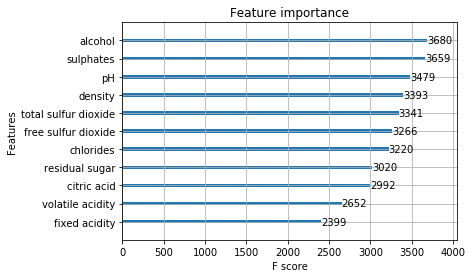

In [91]:
xgb.plot_importance(model_xgb).set_yticklabels(df.columns)
plt.savefig('123.jpg')

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')